# Cosine Similarity Analysis of Model Predictions During Denoising

This notebook analyzes the cosine similarity between model predictions and ground truth velocities during the denoising process. We'll:

1. Load a trained model from a checkpoint
2. Perform denoising for a single example and track velocities
3. Calculate cosine similarities between model predictions and ground truth velocities
4. Visualize the results
5. Extend the analysis to multiple examples and compute statistics
6. Visualize top-k tokens for each denoising step with probabilities and L2 distances

In [6]:
import os
import sys
from pathlib import Path

import lightning as pl
import matplotlib.pyplot as plt
import numpy as np
import torch
from omegaconf import OmegaConf
from torch import Tensor
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

from datasets import Dataset

# Add parent directory to path to import shortcutfm modules
sys.path.append('..')
from shortcutfm.analysis.denoising import denoise_with_velocity_tracking
from shortcutfm.batch import collate
from shortcutfm.config import TrainingConfig
from shortcutfm.text_datasets import TextDataset
from shortcutfm.train.pl.trainer_factory import (
    create_criterion,
    load_unit_from_checkpoint,
)
from shortcutfm.analysis.token_analysis import (
    analyze_token_predictions,
    denoise_with_token_tracking,
    visualize_top_k_tokens,
)
from typing import Any


In [7]:
# Set the checkpoint directory
checkpoint_dir = Path("../checkpoints/run_utah29ps")
checkpoint_path = checkpoint_dir / "last.ckpt"
training_config_path = checkpoint_dir / "training_config.yaml"

# Load training configuration
with open(training_config_path) as f:
    yaml_cfg = OmegaConf.load(f)

training_config = TrainingConfig(**OmegaConf.to_container(yaml_cfg, resolve=True))
print(f"Loaded training config from {training_config_path}")

Loaded training config from ..\checkpoints\run_utah29ps\training_config.yaml


In [8]:
# Set random seed for reproducibility
pl.seed_everything(training_config.seed)

# Create criterion and load model from checkpoint
criterion = create_criterion(training_config)
unit = load_unit_from_checkpoint(criterion, checkpoint_path, training_config)
print(f"Loaded model from {checkpoint_path}")

# Set the model to evaluation mode
unit.eval()
print("UNIT lodaed succesfully")

Seed set to 44


Loaded model from ..\checkpoints\run_utah29ps\last.ckpt
UNIT lodaed succesfully


In [9]:
tokenizer = unit.criterion.flow_matching_criterion.tokenizer

In [ ]:

vocab = tokenizer.get_vocab()

# Filter unused tokens
unused_tokens = [token for token in vocab.keys() if token.startswith('[unused')]

# Print unused tokens and their corresponding IDs
for token in unused_tokens:
    print(f"Token: {token}, ID: {vocab[token]}")


In [ ]:
from transformers import AutoTokenizer, PreTrainedTokenizerFast

tokenizer = AutoTokenizer.from_pretrained('answerdotai/ModernBERT-base')

# Get the vocabulary
vocab = tokenizer.get_vocab()

# Filter unused tokens
unused_tokens = [token for token in vocab.keys() if token.startswith('[unused')]

# Print unused tokens and their corresponding IDs
for token in unused_tokens:
    print(f"Token: {token}, ID: {vocab[token]}")

## Load Test Data

Now we'll load some test data to use for our analysis.

In [10]:
# Load test dataset
from shortcutfm.batch import EncoderBatch


test_data_path = "../datasets/tokenized/bert-base-uncased/QQP-Official/valid"
test_ds = Dataset.load_from_disk(test_data_path)
test_text_ds = TextDataset(test_ds)

# Create a small batch for analysis
batch_size = 8
test_dataloader = DataLoader(
    test_text_ds,
    batch_size=batch_size,
    collate_fn=collate,
    shuffle=False,
)

# Get a single batch for analysis
test_batch: EncoderBatch = next(iter(test_dataloader))
print(f"Loaded test batch with {len(test_batch.seqs)} examples")

Loaded test batch with 8 examples


## Single Example Analysis

Let's analyze the denoising process for a single example.

In [12]:
# Set shortcut size for denoising
shortcut_size = 128


In [13]:

# Run denoising with tracking
results = denoise_with_velocity_tracking(unit.criterion.flow_matching_criterion, test_batch, shortcut_size, per_token_cosine=True)

# Extract results
timesteps = results["timesteps"]
cosine_similarities = [cs.cpu().numpy() for cs in results["cosine_similarities"]]

# Convert to numpy for easier plotting
cosine_similarities_np = np.array([cs.mean().item() for cs in cosine_similarities])

print(f"Analyzed denoising process with {len(timesteps)} steps")
cosine_similarities
# results

Analyzed denoising process with 16 steps


[array([0.06512219, 0.13281289, 0.08440544, 0.05001614, 0.2048624 ,
        0.13504858, 0.07381611, 0.3164694 ], dtype=float32),
 array([0.17559175, 0.2494853 , 0.17591968, 0.16252474, 0.2757418 ,
        0.25904876, 0.20044859, 0.44225714], dtype=float32),
 array([0.28950503, 0.35905638, 0.3038175 , 0.2990699 , 0.3733631 ,
        0.34343556, 0.30181012, 0.54132086], dtype=float32),
 array([0.38703457, 0.4447797 , 0.39369857, 0.40522078, 0.45507836,
        0.42773485, 0.40182382, 0.61369157], dtype=float32),
 array([0.48632243, 0.52433777, 0.4852477 , 0.5065601 , 0.536246  ,
        0.53152454, 0.50740314, 0.67541295], dtype=float32),
 array([0.5212625 , 0.56263345, 0.5184806 , 0.5602635 , 0.57522005,
        0.54237366, 0.5517329 , 0.699038  ], dtype=float32),
 array([0.5439167 , 0.5796512 , 0.53586507, 0.5828042 , 0.5958768 ,
        0.5553958 , 0.5700799 , 0.71173084], dtype=float32),
 array([0.55091524, 0.5853758 , 0.5526036 , 0.59945005, 0.60535204,
        0.5676613 , 0.5939547

In [14]:
# Compare per-token vs flattened cosine similarity calculations and plot with L2 distances
results_per_token = denoise_with_velocity_tracking(
    unit.criterion.flow_matching_criterion,
    test_batch, 
    shortcut_size,
    per_token_cosine=True,
    step_size=2048/12
)
# results_flattened = denoise_with_tracking(unit, test_batch, 4, per_token_cosine=False)

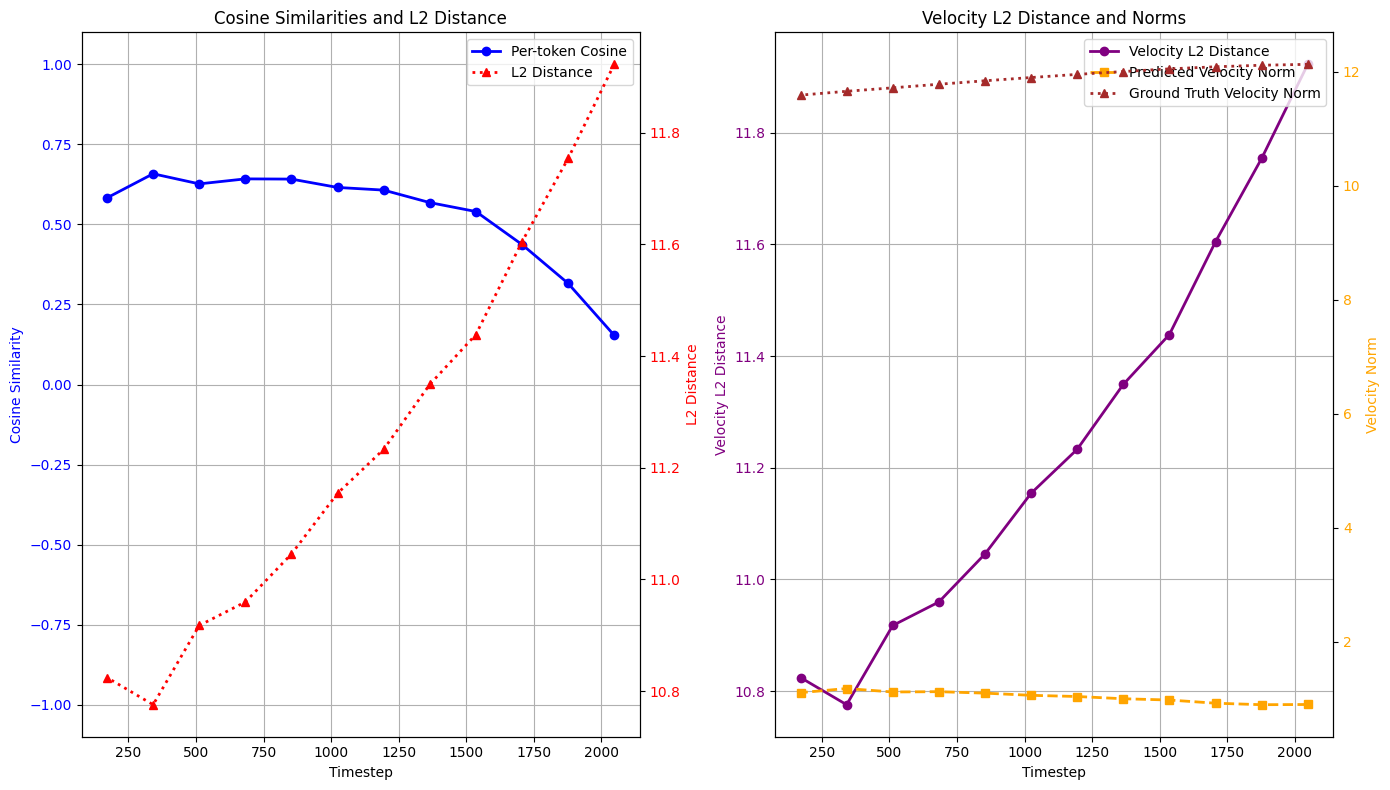

In [16]:
# Extract results
timesteps = results_per_token["timesteps"]
# Take mean across batch dimension for each metric
cosine_similarities_per_token = [cs.cpu().numpy().mean() for cs in results_per_token["cosine_similarities"]]
l2_distances = [d.cpu().numpy().mean() for d in results_per_token["l2_distances"]]
velocity_l2_distances = [d.cpu().numpy().mean() for d in results_per_token["velocity_l2_distances"]]
predicted_velocity_norms = [n.cpu().numpy().mean() for n in results_per_token["predicted_velocity_norms"]]
ground_truth_velocity_norms = [n.cpu().numpy().mean() for n in results_per_token["ground_truth_velocity_norms"]]

# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))

# First subplot - Cosine similarities and L2 distances
ax1.plot(timesteps, cosine_similarities_per_token, marker='o', linestyle='-', linewidth=2, color='blue', label='Per-token Cosine')
ax1.set_xlabel('Timestep')
ax1.set_ylabel('Cosine Similarity', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(-1.1, 1.1)
ax1.grid(True)

# Create twin axis for L2 distances
ax1_twin = ax1.twinx()
ax1_twin.plot(timesteps, l2_distances, marker='^', linestyle=':', linewidth=2, color='red', label='L2 Distance')
ax1_twin.set_ylabel('L2 Distance', color='red')
ax1_twin.tick_params(axis='y', labelcolor='red')

# Add title and legend for first subplot
ax1.set_title('Cosine Similarities and L2 Distance')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_twin.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Second subplot - Velocity L2 distances and norms
ax2.plot(timesteps, velocity_l2_distances, marker='o', linestyle='-', linewidth=2, color='purple', label='Velocity L2 Distance')
ax2.set_xlabel('Timestep')
ax2.set_ylabel('Velocity L2 Distance', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')
ax2.grid(True)

# Create twin axis for velocity norms
ax2_twin = ax2.twinx()
ax2_twin.plot(timesteps, predicted_velocity_norms, marker='s', linestyle='--', linewidth=2, color='orange', label='Predicted Velocity Norm')
ax2_twin.plot(timesteps, ground_truth_velocity_norms, marker='^', linestyle=':', linewidth=2, color='brown', label='Ground Truth Velocity Norm')
ax2_twin.set_ylabel('Velocity Norm', color='orange')
ax2_twin.tick_params(axis='y', labelcolor='orange')

# Add title and legend for second subplot
ax2.set_title('Velocity L2 Distance and Norms')
lines3, labels3 = ax2.get_legend_handles_labels()
lines4, labels4 = ax2_twin.get_legend_handles_labels()
ax2.legend(lines3 + lines4, labels3 + labels4, loc='upper right')

plt.tight_layout()
plt.show()

In [17]:
# Compare per-token vs flattened cosine similarity calculations and plot with L2 distances
results_per_token = denoise_with_velocity_tracking(
    unit.criterion.flow_matching_criterion,
    test_batch, 
    2048,
    per_token_cosine=True,
    step_size=2048/2
)
# results_flattened = denoise_with_tracking(unit, test_batch, 4, per_token_cosine=False)

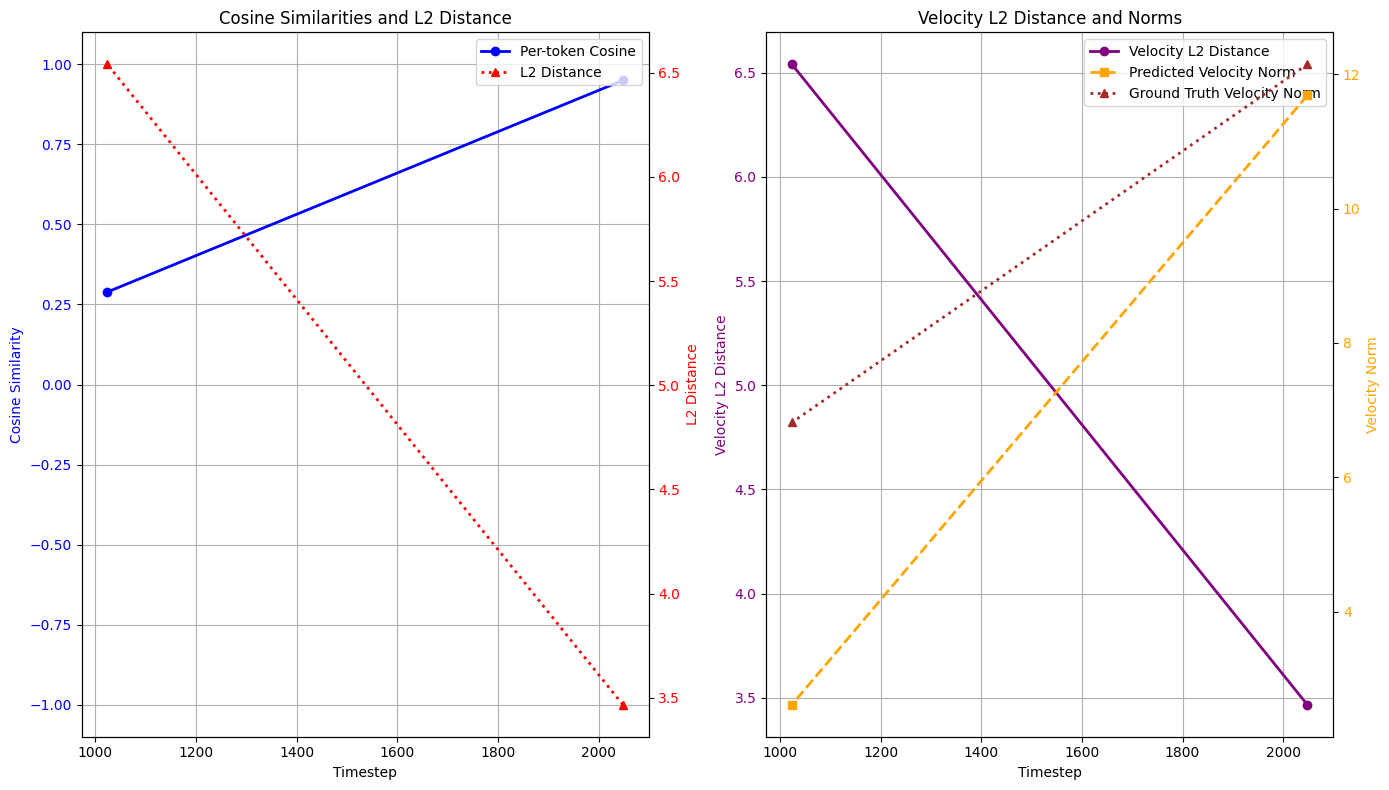

In [33]:
# Extract results
timesteps = results_per_token["timesteps"]
# Take mean across batch dimension for each metric
cosine_similarities_per_token = [cs.cpu().numpy().mean() for cs in results_per_token["cosine_similarities"]]
l2_distances = [d.cpu().numpy().mean() for d in results_per_token["l2_distances"]]
velocity_l2_distances = [d.cpu().numpy().mean() for d in results_per_token["velocity_l2_distances"]]
predicted_velocity_norms = [n.cpu().numpy().mean() for n in results_per_token["predicted_velocity_norms"]]
ground_truth_velocity_norms = [n.cpu().numpy().mean() for n in results_per_token["ground_truth_velocity_norms"]]

# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))

# First subplot - Cosine similarities and L2 distances
ax1.plot(timesteps, cosine_similarities_per_token, marker='o', linestyle='-', linewidth=2, color='blue', label='Per-token Cosine')
ax1.set_xlabel('Timestep')
ax1.set_ylabel('Cosine Similarity', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(-1.1, 1.1)
ax1.grid(True)

# Create twin axis for L2 distances
ax1_twin = ax1.twinx()
ax1_twin.plot(timesteps, l2_distances, marker='^', linestyle=':', linewidth=2, color='red', label='L2 Distance')
ax1_twin.set_ylabel('L2 Distance', color='red')
ax1_twin.tick_params(axis='y', labelcolor='red')

# Add title and legend for first subplot
ax1.set_title('Cosine Similarities and L2 Distance')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_twin.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Second subplot - Velocity L2 distances and norms
ax2.plot(timesteps, velocity_l2_distances, marker='o', linestyle='-', linewidth=2, color='purple', label='Velocity L2 Distance')
ax2.set_xlabel('Timestep')
ax2.set_ylabel('Velocity L2 Distance', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')
ax2.grid(True)

# Create twin axis for velocity norms
ax2_twin = ax2.twinx()
ax2_twin.plot(timesteps, predicted_velocity_norms, marker='s', linestyle='--', linewidth=2, color='orange', label='Predicted Velocity Norm')
ax2_twin.plot(timesteps, ground_truth_velocity_norms, marker='^', linestyle=':', linewidth=2, color='brown', label='Ground Truth Velocity Norm')
ax2_twin.set_ylabel('Velocity Norm', color='orange')
ax2_twin.tick_params(axis='y', labelcolor='orange')

# Add title and legend for second subplot
ax2.set_title('Velocity L2 Distance and Norms')
lines3, labels3 = ax2.get_legend_handles_labels()
lines4, labels4 = ax2_twin.get_legend_handles_labels()
ax2.legend(lines3 + lines4, labels3 + labels4, loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
# import torch
# torch.cuda.empty_cache()

device = torch.device("cuda")
test_batch.seqs = test_batch.seqs.to(device)
test_batch.input_ids_mask = test_batch.input_ids_mask.to(device)
test_batch.padding_mask = test_batch.padding_mask.to(device)
res = unit.criterion.flow_matching_criterion.denoise(test_batch, shortcut_size=2048, return_decoded=True, step_size=128)
for example in res:
    for timestep in example[::-1]:
        print(timestep)
    
    break


In [ ]:
def calculate_noise_to_target_distance(
    target_embeddings: Tensor,
    input_mask: Tensor,
    padding_mask: Tensor,
    num_samples: int = 100,
) -> dict[str, float]:
    """
    Calculate L2 distance and velocity norm between random noise and target embeddings.

    Args:
        target_embeddings: Target embeddings [batch_size, seq_len, hidden_dim]
        input_mask: Mask indicating input positions (0 for input, 1 for target) [batch_size, seq_len, 1]
        padding_mask: Mask indicating padding (0 for padding, 1 for actual tokens) [batch_size, seq_len, 1]
        num_samples: Number of random noise samples to generate

    Returns:
        Dictionary containing:
        - mean_distance: Mean L2 distance across all samples
        - std_distance: Standard deviation of L2 distances
        - min_distance: Minimum L2 distance observed
        - max_distance: Maximum L2 distance observed
    """
    distances = []
    valid_token_mask = input_mask.squeeze(-1).bool() & padding_mask.bool()

    for _ in range(num_samples):
        # Generate random noise with same shape as target embeddings
        noise = torch.randn_like(target_embeddings)
        
        # Calculate L2 distances only for valid tokens
        l2_dists = torch.norm(
            noise[valid_token_mask] - target_embeddings[valid_token_mask],
            dim=-1
        )  # [num_valid_tokens]
        
        # Average L2 distance and velocity norm across valid tokens
        mean_dist = l2_dists.mean().item()
        distances.append(mean_dist)

    distances = torch.tensor(distances)
    
    return {
        "mean_distance": distances.mean().item(),
        "std_distance": distances.std().item(),
        "min_distance": distances.min().item(),
        "max_distance": distances.max().item(),
    }

In [ ]:
# Example usage
device = "cuda" if torch.cuda.is_available() else "cpu"

target_embeddings = unit.criterion.model.get_embeddings(test_batch.seqs.to(device))
distances = calculate_noise_to_target_distance(
    target_embeddings=target_embeddings,
    input_mask=test_batch.input_ids_mask,
    padding_mask=test_batch.padding_mask,
    num_samples=100  # Generate 100 random noise samples
)

print(f"Mean L2 distance: {distances['mean_distance']:.4f}")
print(f"Std L2 distance: {distances['std_distance']:.4f}")
print(f"Min L2 distance: {distances['min_distance']:.4f}")
print(f"Max L2 distance: {distances['max_distance']:.4f}")


Visualizing top-k tokens for each denoising step...


d:\Side-Projects\ShortcutFM\notebooks\..\shortcutfm\analysis\token_analysis.py:332: UserWarning: Glyph 2346 (\N{DEVANAGARI LETTER PA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
d:\Side-Projects\ShortcutFM\notebooks\..\shortcutfm\analysis\token_analysis.py:332: UserWarning: Matplotlib currently does not support Devanagari natively.
  plt.tight_layout()
d:\Side-Projects\ShortcutFM\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2346 (\N{DEVANAGARI LETTER PA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Side-Projects\ShortcutFM\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)


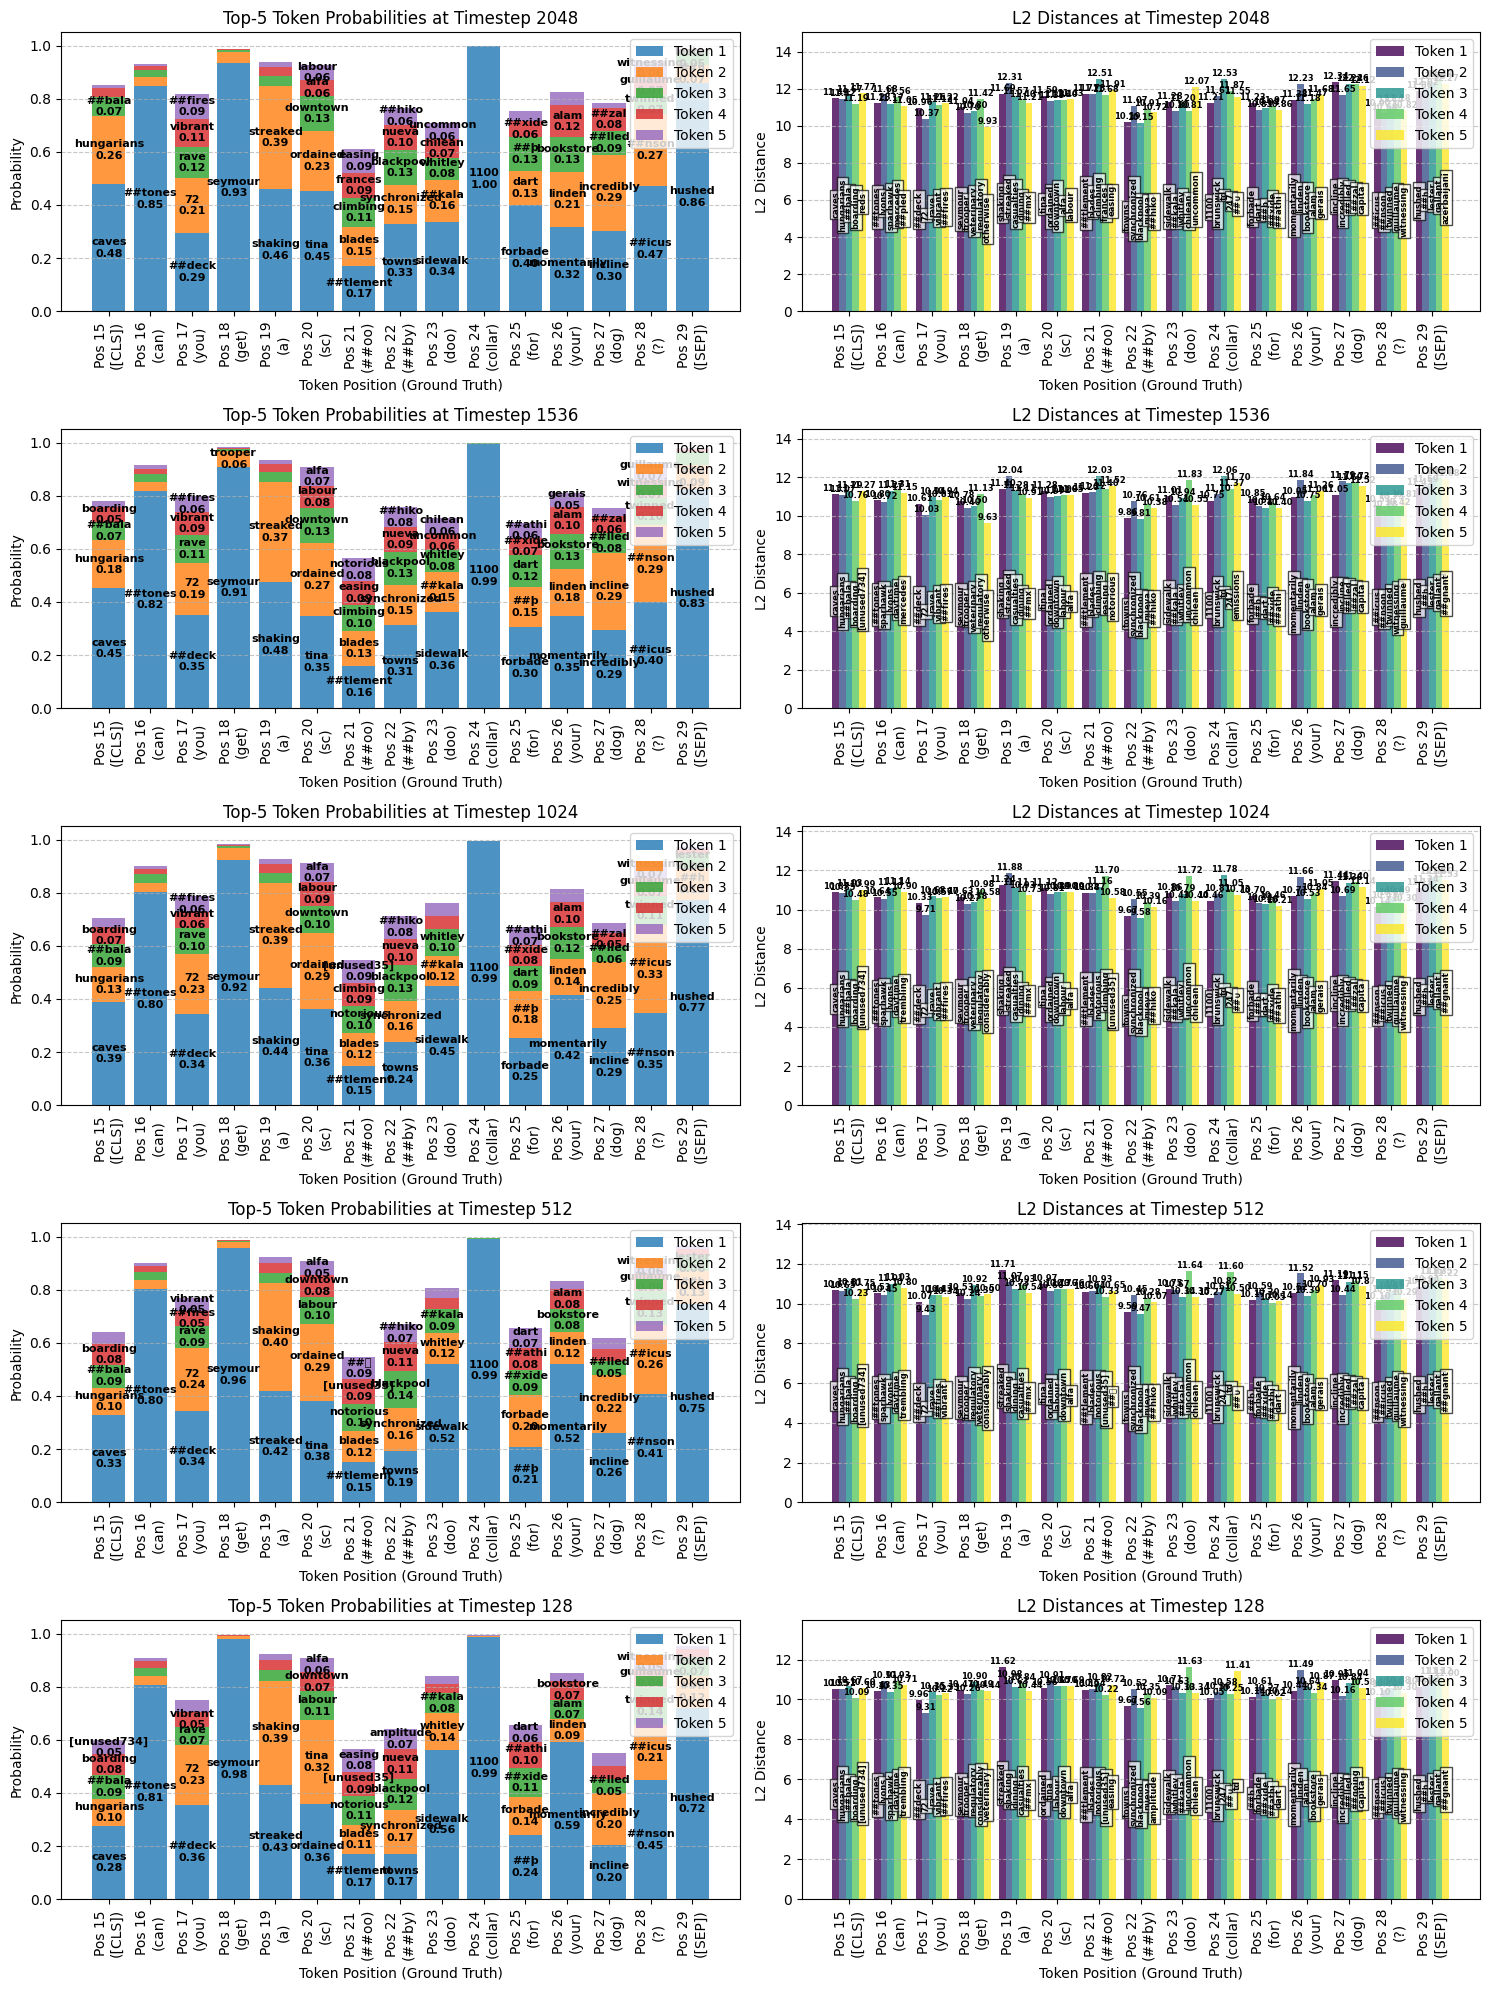

In [18]:
# Visualize top-k tokens for each denoising step
print("\nVisualizing top-k tokens for each denoising step...")
token_results = denoise_with_token_tracking(unit, test_batch, shortcut_size, top_k=5)

# Select a few representative timesteps to visualize
timesteps = token_results["timesteps"]
num_steps = len(timesteps)

# Choose timesteps at different points in the denoising process
timestep_indices = [0, num_steps // 4, num_steps // 2, 3 * num_steps // 4, num_steps - 1]

# Visualize the selected timesteps
visualize_top_k_tokens(token_results, timestep_indices=timestep_indices)

## Individual Example Analysis

Let's look at the cosine similarities for each example in the batch.

## Batch Analysis

Now let's analyze multiple batches to get more robust statistics.

In [ ]:
def analyze_multiple_batches(model, dataloader, shortcut_size, num_batches=5):
    """
    Analyze cosine similarities across multiple batches.
    
    Args:
        model: The model to use for denoising
        dataloader: DataLoader providing batches
        shortcut_size: Shortcut size for denoising
        num_batches: Number of batches to analyze
        
    Returns:
        Dictionary with aggregated statistics
    """
    all_cosine_sims = []
    timesteps = None

    # Process multiple batches
    dataloader_iter = iter(dataloader)
    for i in tqdm(range(num_batches), desc="Processing batches"):
        try:
            batch = next(dataloader_iter)
        except StopIteration:
            break

        # Run denoising with tracking
        results = denoise_with_tracking(model, batch, shortcut_size, per_token_cosine=True)

        # Store timesteps from first batch
        if timesteps is None:
            timesteps = results["timesteps"]

        # Extract and store cosine similarities
        batch_cos_sims = [cs.cpu().numpy() for cs in results["cosine_similarities"]]
        all_cosine_sims.append(batch_cos_sims)

    # Aggregate results
    num_steps = len(timesteps)
    aggregated_cos_sims = []

    for step in range(num_steps):
        step_sims = []
        for batch_idx in range(len(all_cosine_sims)):
            step_sims.extend(all_cosine_sims[batch_idx][step])
        aggregated_cos_sims.append(np.array(step_sims))

    # Calculate statistics for each timestep
    mean_cos_sims = np.array([sims.mean() for sims in aggregated_cos_sims])
    std_cos_sims = np.array([sims.std() for sims in aggregated_cos_sims])
    min_cos_sims = np.array([sims.min() for sims in aggregated_cos_sims])
    max_cos_sims = np.array([sims.max() for sims in aggregated_cos_sims])

    return {
        "timesteps": timesteps,
        "mean": mean_cos_sims,
        "std": std_cos_sims,
        "min": min_cos_sims,
        "max": max_cos_sims,
        "all_data": aggregated_cos_sims
    }

In [ ]:
# Create a larger test dataloader for batch analysis
batch_size = 16
test_dataloader = DataLoader(
    test_text_ds,
    batch_size=batch_size,
    collate_fn=collate,
    shuffle=False,
)

# Analyze multiple batches
batch_results = analyze_multiple_batches(unit, test_dataloader, shortcut_size, num_batches=5)

In [ ]:
# Plot mean cosine similarity with error bands
plt.figure(figsize=(14, 8))

timesteps = batch_results["timesteps"]
mean_cos_sims = batch_results["mean"]
std_cos_sims = batch_results["std"]

plt.plot(timesteps, mean_cos_sims, 'b-', linewidth=2, label='Mean Cosine Similarity')
plt.fill_between(timesteps,
                 mean_cos_sims - std_cos_sims,
                 mean_cos_sims + std_cos_sims,
                 alpha=0.3,
                 color='b',
                 label='±1 Std Dev')

plt.plot(timesteps, batch_results["min"], 'r--', linewidth=1, label='Min Cosine Similarity')
plt.plot(timesteps, batch_results["max"], 'g--', linewidth=1, label='Max Cosine Similarity')

plt.title('Mean Cosine Similarity Between Predicted and Ground Truth Velocities (Multiple Batches)')
plt.xlabel('Timestep')
plt.ylabel('Cosine Similarity')
plt.grid(True)
plt.ylim(-1.1, 1.1)  # Cosine similarity range
plt.legend()
plt.tight_layout()
plt.show()

## Distribution of Cosine Similarities

Let's visualize the distribution of cosine similarities at different timesteps.

In [ ]:
timesteps

In [ ]:
# Select a few representative timesteps to visualize
timesteps = batch_results["timesteps"]
num_steps = len(timesteps)

# Choose timesteps at different points in the denoising process
# Ensure we get unique timesteps by checking the actual timestep values
indices_to_plot = []
timesteps_to_plot = []

# Add first timestep
indices_to_plot.append(0)
timesteps_to_plot.append(timesteps[0])

# Add a few timesteps in between
potential_indices = [num_steps // 4, num_steps // 2, 3 * num_steps // 4]
for idx in potential_indices:
    ts = timesteps[idx]
    if ts not in timesteps_to_plot:  # Only add if this timestep isn't already in our list
        indices_to_plot.append(idx)
        timesteps_to_plot.append(ts)

# Add last timestep if it's different from what we already have
if timesteps[-1] not in timesteps_to_plot:
    indices_to_plot.append(num_steps - 1)
    timesteps_to_plot.append(timesteps[-1])

# Create histogram plots
if len(indices_to_plot) > 0:  # Only create plots if we have timesteps to plot
    fig, axes = plt.subplots(len(indices_to_plot), 1, figsize=(12, 4 * len(indices_to_plot)))

    # Handle the case where we only have one unique timestep
    if len(indices_to_plot) == 1:
        axes = [axes]  # Make axes a list with one element

    for i, (idx, ts) in enumerate(zip(indices_to_plot, timesteps_to_plot, strict=False)):
        ax = axes[i]
        cos_sims = batch_results["all_data"][idx]

        ax.hist(cos_sims, bins=30, alpha=0.7, color='blue')
        ax.axvline(x=cos_sims.mean(), color='r', linestyle='--', linewidth=2, label=f'Mean: {cos_sims.mean():.4f}')

        ax.set_title(f'Distribution of Cosine Similarities at Timestep {ts}')
        ax.set_xlabel('Cosine Similarity')
        ax.set_ylabel('Frequency')
        ax.set_xlim(-1.1, 1.1)
        ax.legend()

    plt.tight_layout()
    plt.show()
else:
    print("No unique timesteps found to plot.")

## Conclusion

In this notebook, we've analyzed the cosine similarity between model predictions and ground truth velocities during the denoising process. This analysis provides insights into how well the model is learning to predict the correct direction of change at different timesteps.

Key observations:
1. The cosine similarity varies across different timesteps, indicating that the model's prediction accuracy changes during the denoising process.
2. There is variation in cosine similarity across different examples, suggesting that some examples are easier for the model to predict than others.
3. The distribution of cosine similarities at different timesteps provides insights into the model's behavior at different stages of denoising.

## Token Probability and L2 Distance Analysis

Let's analyze the top-k tokens for each denoising step, showing both probabilities and L2 distances.

In [ ]:
# Load a test batch
test_batch = next(iter(test_dataloader))

# Set shortcut size for denoising
shortcut_size = 1024

# Run token tracking for a specific example
print("Running token tracking for a specific example...")
token_results = denoise_with_token_tracking(unit, test_batch, shortcut_size, top_k=5, example_idx=0)

# Get the original input sequence
input_ids = test_batch.seqs[0].cpu().numpy()
input_mask = test_batch.input_ids_mask[0].cpu().numpy()
padding_mask = test_batch.padding_mask[0].cpu().numpy()

# Print the input sequence
print("\nInput sequence (showing only non-padding tokens):")
tokens = []
for i, (token_id, is_padding) in enumerate(zip(input_ids, padding_mask, strict=False)):
    if is_padding:
        is_input = "Input" if input_mask[i] == 0 else "Target"
        token_text = unit.criterion.flow_matching_criterion.tokenizer.decode([token_id])
        tokens.append(f"{i}: {token_text} ({is_input})")

print("\n".join(tokens))

# Print the positions that contribute to the loss
print("\nPositions that contribute to the loss (non-input, non-padding):")
print(token_results["loss_positions"])

# Select specific timesteps to visualize
timesteps = token_results["timesteps"]
num_steps = len(timesteps)

# Choose timesteps at different points in the denoising process
if num_steps >= 5:
    timestep_indices = [0, num_steps // 4, num_steps // 2, 3 * num_steps // 4, num_steps - 1]
else:
    timestep_indices = list(range(num_steps))

# Visualize the selected timesteps
visualize_top_k_tokens(token_results, timestep_indices=timestep_indices, figsize=(15, 4 * len(timestep_indices)))

# Print the top tokens at the final timestep
print("\nTop tokens at the final timestep:")
final_timestep = token_results["timesteps"][-1]
final_token_texts = token_results["token_texts"][-1]
final_token_probs = token_results["token_probs"][-1]

for pos_idx, pos in enumerate(token_results["loss_positions"]):
    print(f"Position {pos}:")
    for token_idx, (token, prob) in enumerate(zip(final_token_texts[pos_idx], final_token_probs[pos_idx], strict=False)):
        print(f"  {token_idx+1}. {token} (prob: {prob:.4f})")
    print()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

timesteps = results["timesteps"]
cosine_similarities = results["cosine_similarities"]
predicted_velocity_norms = np.array(results["predicted_velocity_norms"])
ground_truth_velocity_norms = np.array(results["ground_truth_velocity_norms"])
norm_diff = predicted_velocity_norms - ground_truth_velocity_norms

# Plot for each example
plt.figure(figsize=(14, 8))

for i in range(cosine_similarities[0].shape[0]):
    example_cos_sims = [cs[i].cpu().item() for cs in cosine_similarities]
    plt.plot(timesteps, example_cos_sims, marker='.', linestyle='-', label=f'CosSim Example {i+1}')

plt.xlabel('Timestep')
plt.ylabel('Cosine Similarity')
plt.ylim(-1.1, 1.1)
plt.grid(True)

# Plot norm difference on a secondary y-axis
ax2 = plt.gca().twinx()
ax2.plot(timesteps, norm_diff, color='black', marker='x', linestyle='--', label='Norm Difference (Pred - GT)')
ax2.set_ylabel('Norm Difference')
ax2.legend(loc='upper right')

plt.title('Cosine Similarity and Velocity Norm Difference During Denoising')
plt.tight_layout()
plt.show()

In [ ]:
import torch

input1 = torch.randn(100, 128)
input2 = torch.randn(100, 128)
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
output = cos(input1, input2)
output

In [ ]:
output.shape